# Pedestrian Analysis
# on Linked Data: Crash (MV104) + Hospital (SPARCS)

Analysis Part 2: Evaluating New KSI Formulas

In [2]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np
import itertools
from patsy import dmatrices
import statsmodels.api as sm

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import analysis as an

import sys
sys.path.insert(0, '../2-Data/')
import databuild as db


## Pedestrian/Bicyclist Data
The MV104 crash database is compiled by DMV into three tables: 
* crash table, 
* person table, and 
* vehicle table. 

The databuild.py script reads in the tables and organizes them into a person level table for pedestrians or bicyclists involved in 1-vehicle crashes.

The script also reads in the linked hospital-crash data from DOHMH and adds the hospital info (e.g. the person's b-ISS score) onto the ped file.

The resulting dataframe (ped) is what the rest of the analyis in this notebook uses. It only includes injured people who were able to be linked to hopital data by DOHMH.

In [3]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()

# reorganize into pedestrian/bicyclist 1-veh crashes
ped = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()

# included biss data from linked onto ped (dropping anything not in linked)
ped = db.mergeBiss(ped,linked)

#format and categorize variables
ped = db.formatVars(ped)

print 'linked ped',ped.shape

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


full crash table (522108, 26)
full person table (1502797, 22)
full vehicle table (1092922, 20)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,9,20,25,35,48,54,58,63,65,85,89,102,126,128,129,138) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pedestrians/bicyclists (police reported) (single vehicle) (95292, 80)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
linked ped (17624, 106)


## New KSI formulas
1. KABCO plus
1. Scoring Method

The Severity Ratio (explored in the AnalysisSeverityRatio.ipynb) gives us a way of understanding which crash attributes are important. In this notebook we try to understand more quantitatively the impact of using one or more of those attributes in a formulat that labels crashes severe or not severe.

## Metrics
used to evaluate new formulas compared to the existing KABCO formula created by DMV. 

**Precision**:  for crashes predicted ‘severe’ how many actually are? "Correctness" of labeled values

    True Positive / (True Positive + False Positive)
 
**Recall**: for crashes which are actually ‘severe’ how many are predicted correctly? "Capture rate"
    
    True Positive / (True Positive + False Negative)


##  1.  KABCO plus 

The "KABCO plus" formulas give a severe label to anything that is labeled K or A from KABCO plus one of the selected attributes: 
* person's age is 70+, 
* there is a head injury, 
* the other vehicle is a truck or motorcycle,
* any of the above. 

We chose these attributes because they all ranked high on the Severity Ratio.


In [3]:
# dataframe that stores precision and recall information for the various models.
ksiplus = pd.DataFrame(columns=['FracCrashes','Precision','Recall',
                                'pLow','pHigh','rLow','rHigh'])

def addRow(data, N=100,frac=1):
    ''' returns a row to add to the the ksiplus dataframe
    data = injured person data 
    N = number of samples to use for bootstrapping
    frac = fraction of data to use for resampling
    
    '''
    #precision recall
    yPred = (data.newSev=='severe').astype(int)
    yActual = (data.biss_severity_9=='severe').astype(int)
    prec, recall = an.prec_recall(y_actual=yActual,y_predict=yPred, threshold=.5)
    fracCrashes = yPred.sum()/float(yPred.shape[0])
    
    # error bars
    precSample = []
    recSample = []
    for i in range(N):
        df = data.sample(frac=frac,replace=True)

        yPred = (df.newSev=='severe').astype(int)
        yActual = (df.biss_severity_9=='severe').astype(int)

        p,r = an.prec_recall(y_actual=yActual,y_predict=yPred,threshold=.5)

        precSample.append(p)
        recSample.append(r)

    pLow,pHigh = np.percentile(precSample,5),np.percentile(precSample,95)
    rLow,rHigh = np.percentile(recSample,5),np.percentile(recSample,95)

    row=[fracCrashes, prec, recall, pLow,pHigh,rLow,rHigh]
    return row

In [4]:
# baseline: K,A from KABCO
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'

ksiplus.loc['K,A']= addRow(ped,N=100)

# 70plus: age 70+
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_AgeYear>=70,'newSev'] = 'severe'

ksiplus.loc['K,A + age 70+']= addRow(ped,N=100)

# head: any head injury
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_InjuryLoc=='Head','newSev'] = 'severe'

ksiplus.loc['K,A + head injury']= addRow(ped,N=100)

# vehicle: vehicle = Truck, Motorcycle
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_OtherVehTypeVIN.isin(['Motorcycle','Truck']),'newSev'] = 'severe'

ksiplus.loc['K,A + motorcycle,truck']= addRow(ped,N=100)

# all: all of the above
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_AgeYear>=70,'newSev'] = 'severe'
ped.loc[ped.f_InjuryLoc=='Head','newSev'] = 'severe'
ped.loc[ped.f_OtherVehTypeVIN.isin(['Motorcycle','Truck']),'newSev'] = 'severe'

ksiplus.loc['all above']= addRow(ped,N=100)


ksiplus


,FracCrashes,Precision,Recall,pLow,pHigh,rLow,rHigh
"K,A",0.137596,0.308866,0.438525,0.292123,0.322276,0.419440,0.457517
"K,A + age 70+",0.191954,0.268992,0.532787,0.257557,0.281690,0.506905,0.554396
"K,A + head injury",0.244269,0.229501,0.578454,0.219841,0.240011,0.558886,0.594804
"K,A + motorcycle,truck",0.146562,0.298103,0.450820,0.283026,0.309543,0.431043,0.467005
all above,0.295393,0.214176,0.652810,0.203442,0.223693,0.632139,0.672602


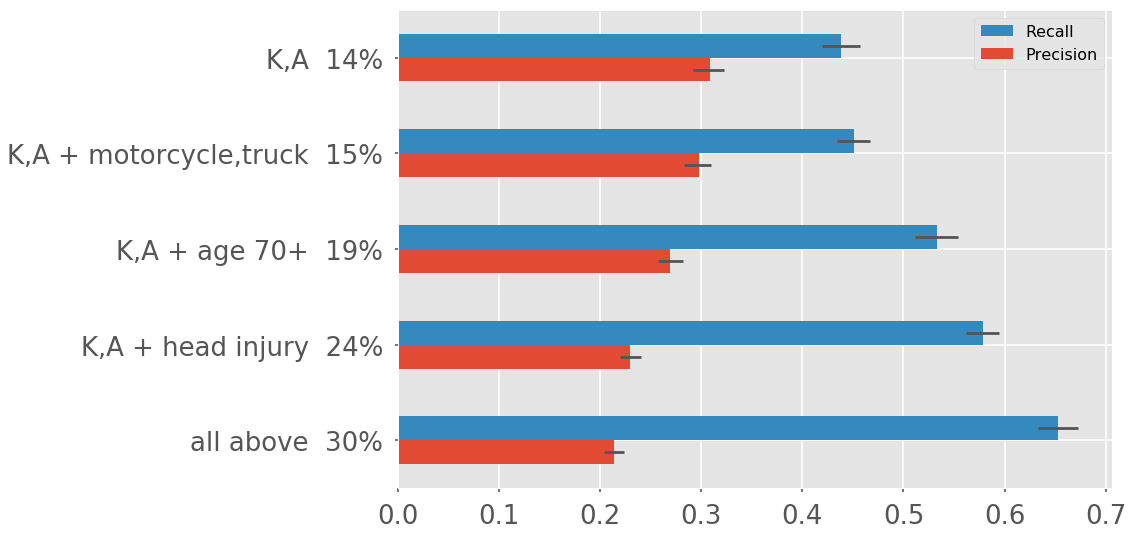

In [5]:
ksiplus.sort_values('Precision',inplace=True)
ksiplus.index = ksiplus.index +'  '\
    + (ksiplus.FracCrashes.astype(float)*100).round(0).astype(int).astype(str)+'%'

# error bars
ksiplus['pDeltaLow'] = ksiplus['Precision'] - ksiplus['pLow'] 
ksiplus['pDeltaHigh'] = ksiplus['pHigh'] - ksiplus['Precision']

ksiplus['rDeltaLow'] = ksiplus['Recall'] - ksiplus['rLow']
ksiplus['rDeltaHigh'] = ksiplus['rHigh'] - ksiplus['Recall']

perror = ksiplus[['pDeltaLow','pDeltaHigh']].T.values
rerror = ksiplus[['rDeltaHigh','rDeltaHigh']].T.values

error = [perror,rerror]

ksiplus[['Precision','Recall']].plot(kind='barh',xerr=error,fontsize=26,
                               legend='reverse')

**Takeaway**

* With this method, you can increase the recall, which means capturing more of the actually severe (b-ISS 9+) cases. But that sacrifices precision, meaning less of the labeled severe actually are. 

The next method is more flexible, allowing us to hold precision constant while increasing recall. The tradeoff is that it is more complicated to state which crashes are labeled severe.

## 2. Scoring Method 
 (using Logistic Regression models)
 
The rest of this notebook goes through the Scoring Method and how we come up with the attribute scores and threshold.

The general framework is:

* Assign a score to each crash attribute
* For each crash, add up total score based on which attributes are present
* Crashes with scores above a threshold are considered severe

Attribute scores are determined by fitting the data to a logistic regression model. 

The threshold determines where the output of the logit changes from not severe to severe. This threshold will be determined by choosing a point along the precision recall curve where the precision is equal to the baseline DMV/KABCO precision and the recall is optimized.

We use the optimal recall to determine which logistic regression model to use (the models are defined by the input variables (attributes) used). This process is called variable selection.

The function fitPlotMult() fits a logistic regression model to 80% of the data, chosen at random. It then uses the remaining 20% to calculate precision recall metrics at different thresholds. The result is plotted on a precision recall graph. The baseline DMV formula (KABCO) is also shown as a point on the graph. 

The first graph below shows the result for one run (N=1). This model only used the three injury variables as input to the model. You can see there is one point along the precision recall curve that intersects with the DMV/KABCO model. So there will be no improvent from the baseline DMV/KABCO formula.

Running this multiple times (N=10 below for example) leads to a distribution of optimal recall. It's randomly choosing a different 80% of the data to train on. We use the distribution to identify confidence intervals. 

The function fitPlotMult() returns a dataframe which gives the optimal recall and the associated precision and threshold for each run. Each row is a different run.

['f_InjuryType', 'f_InjuryStatus', 'f_InjuryLoc']
number of variables 28
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.269169
         Iterations 7
baseline dmv 
 precision   recall
0.31          0.44
optimal recall 0.47


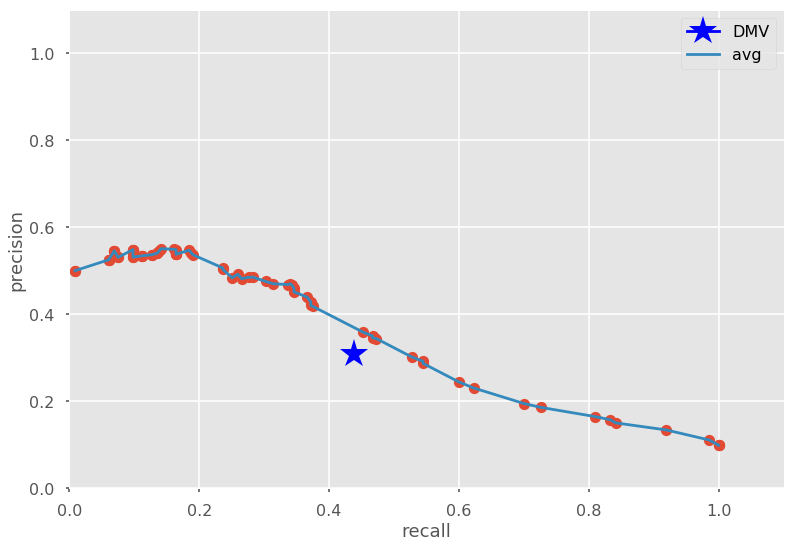

In [6]:
# only using the three injury variables
df = an.fitPlotMult(data=ped,pred=['f_InjuryType','f_InjuryStatus','f_InjuryLoc'],
                    N=1)

In [7]:
df

,index,precision,recall
0,0.15,0.343816,0.472622


['f_InjuryType', 'f_InjuryStatus', 'f_InjuryLoc']
number of variables 28
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.266307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.266872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.266107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.270293
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.269793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267195
         Iterations 7
Optimization terminated success

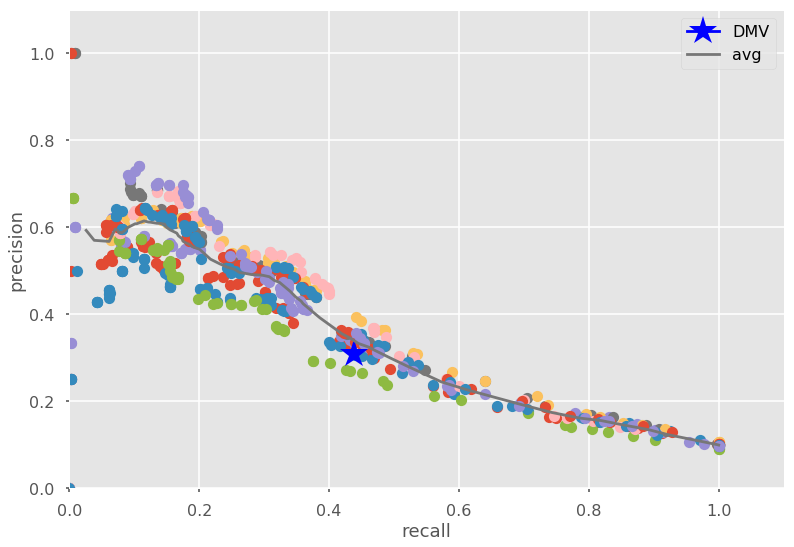

In [8]:
# same as above but 10 runs instead of 1 
df = an.fitPlotMult(data=ped,pred=['f_InjuryType','f_InjuryStatus','f_InjuryLoc'],
                    N=10)

In [9]:
df

,index,precision,recall
0,0.14,0.313953,0.460227
1,0.17,0.325843,0.416667
2,0.13,0.312618,0.475645
3,0.13,0.327652,0.485955
4,0.13,0.311709,0.529570
5,0.20,0.362069,0.331230
6,0.15,0.347737,0.487032
7,0.13,0.319030,0.476323
8,0.14,0.326810,0.484058
9,0.14,0.310606,0.476744


In [10]:
# listing [50%,5%,90%] values
an.median_recall(df)

('0.48', '0.37', '0.51')

By limiting the model to only using the three injury variables, we are not able to improve from the original DMV formula.

If we include ALL the variables we do see a 20-30% increase in the optimal recall compared to the baseline DMV recall.

['f_InjuryType', 'f_InjuryStatus', 'f_InjuryLoc', 'f_Sex', 'f_DriverSex', 'f_AgeDecade', 'f_DriverAgeDecade', 'f_Role', 'f_Eject', 'f_PedLoc', 'f_Lighting', 'f_TimeOfDay', 'f_RoadSurface', 'f_Weather', 'f_TrafficControl', 'f_PedAction', 'f_OtherVehAction', 'f_OtherVehType']
number of variables 93
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.254816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.253653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.249549
         Iterations 8
         Current function value: 0.253314
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.255287
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256938
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256761
         Iterations 8
baseline dmv 
 precision   recall
0.31          0.44
optimal recall 0.56


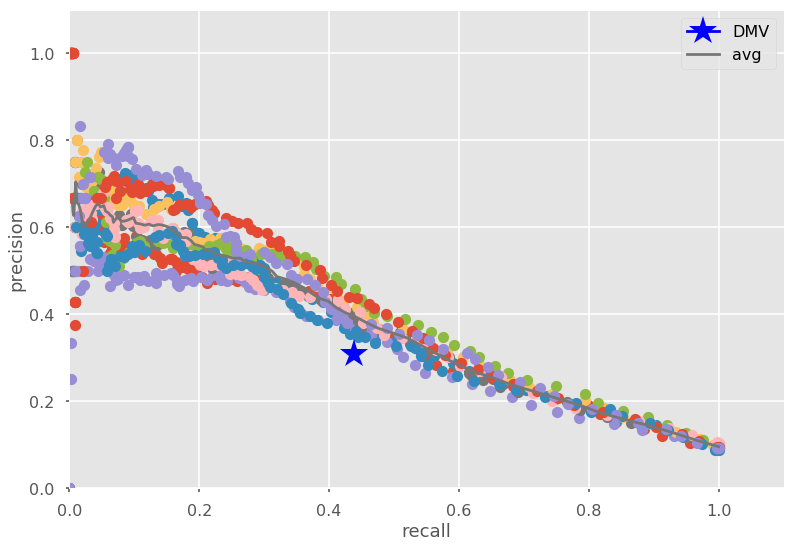

In [11]:
# include all the variables

var = list(ped.filter(like='f_').columns)
# remove redundant variables
remove = ['f_AgeYear','f_Age70','f_DriverAgeYear','f_DriverAge70',
         'f_OtherVehTypeVIN']
allvar = [x for x in var if x not in remove]

df = an.fitPlotMult(data=ped,pred=allvar,N=10)

In [12]:
an.median_recall(df)

('0.56', '0.52', '0.61')

###  Variable Selection
We could use ALL the variables in our scoring formula, but it adds needless complexity. If more variables don't lead to better recall metric, we don't need them in the model.

In order to decide which variables (attributes) to use in the final formula, we will first limit the number of variables and then run through all possibilities. 

Keeping the three injury variables and then add in 2 more of the 15 other variables leads to 105 combinatins (15 choose 2 combinations). 

* Calculate the optimal recall for all variations. 
* Choose the model with the highest optimal recall. We're limiting it to 2 because otherwise the number of combinations becomes intractable. 

Note: Forward and backward selection was tried but did not work well. We re-evaluated and decided to do this 2 variable selection instead.

In [13]:
#baseline recall
y_actual = (ped.biss_severity_9=='severe').astype(int)
y_pred = (ped.SEVERITY.isin(['K','A'])).astype(int)
basePrec, baseRecall = an.prec_recall(y_actual=y_actual,y_predict=y_pred,threshold=.5)

print basePrec,baseRecall

0.3088659793814433 0.4385245901639344


Run all combinations of variable pairs. 
Add pairs to baseline injury variables. 
Capture precision and recall 

In [14]:
# list all variables, only remove injury variables and redundant age variables

var = list(ped.filter(like='f_').columns)
remove = ['f_InjuryType','f_InjuryLoc','f_InjuryStatus',
          'f_AgeYear','f_Age70','f_DriverAgeYear','f_DriverAge70','f_OtherVehType']

varOfInt = [x for x in var if x not in remove]
varOfInt

['f_Sex',
 'f_DriverSex',
 'f_AgeDecade',
 'f_DriverAgeDecade',
 'f_Role',
 'f_Eject',
 'f_PedLoc',
 'f_Lighting',
 'f_TimeOfDay',
 'f_RoadSurface',
 'f_Weather',
 'f_TrafficControl',
 'f_PedAction',
 'f_OtherVehAction',
 'f_OtherVehTypeVIN']

In [18]:
%%capture
models = an.varSelect(data=ped,varOfInt=varOfInt,N=100)

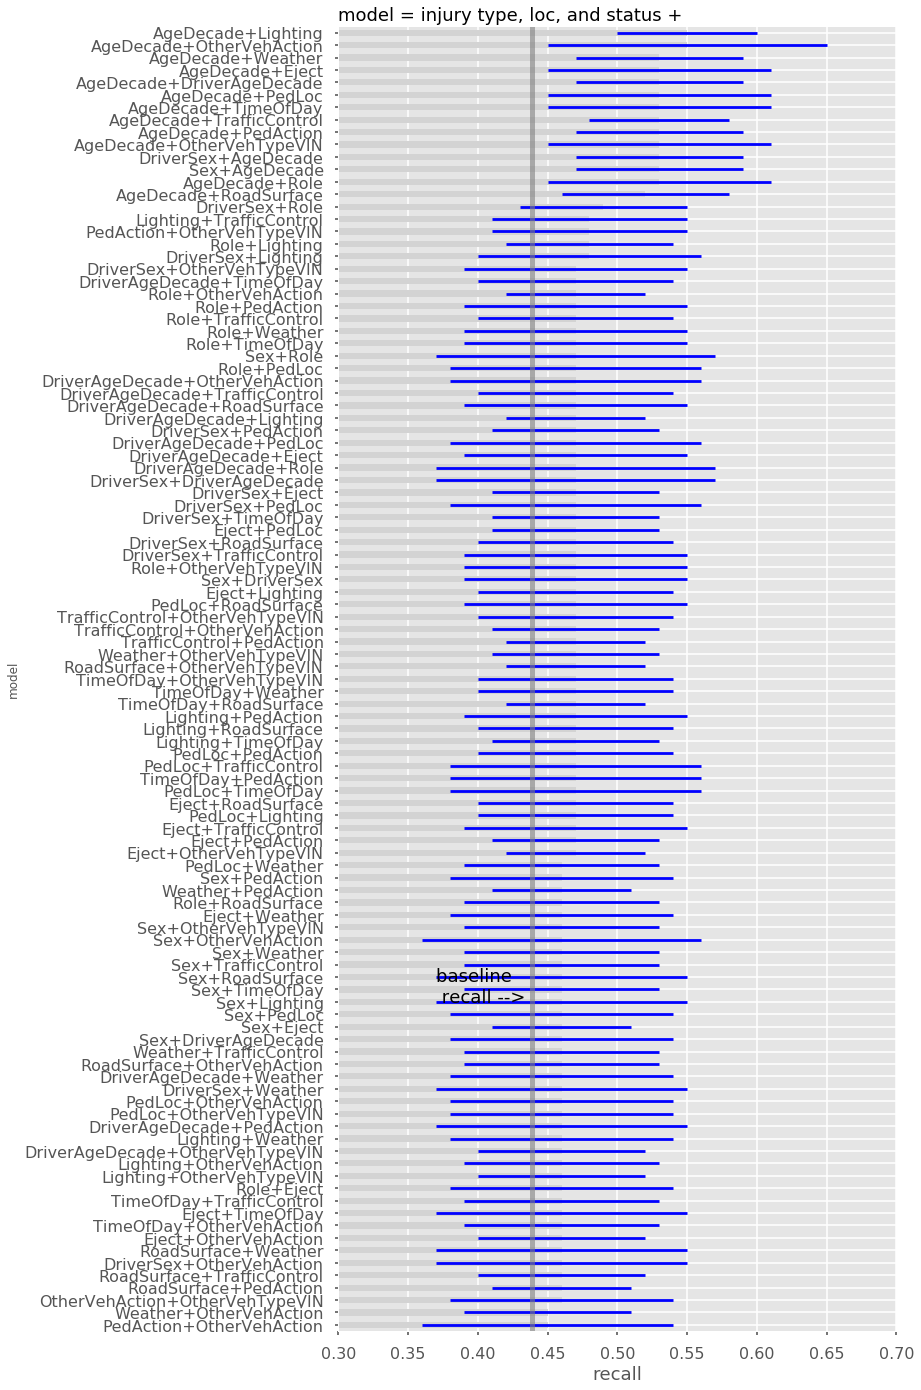

In [19]:
#plot
error = models[['delta low','delta high']].T.values
models[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,24),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,26,'baseline \n recall -->',fontsize=18)

All models where the optimal recall is clearly greater then the baseline (KABCO) recall are shown below. All of them have age as one of the variables in the model.

In [20]:
models[models['recall low']>baseRecall]

,recall,recall low,recall high,delta low,delta high
model,,,,,
Sex+AgeDecade,0.53,0.47,0.60,-0.06,0.07
DriverSex+AgeDecade,0.53,0.47,0.61,-0.06,0.08
AgeDecade+DriverAgeDecade,0.53,0.46,0.60,-0.07,0.07
AgeDecade+Role,0.53,0.44,0.59,-0.09,0.06
AgeDecade+Eject,0.53,0.46,0.60,-0.07,0.07
AgeDecade+PedLoc,0.53,0.46,0.59,-0.07,0.06
AgeDecade+Lighting,0.55,0.45,0.61,-0.10,0.06
AgeDecade+TimeOfDay,0.53,0.46,0.59,-0.07,0.06
AgeDecade+RoadSurface,0.52,0.44,0.59,-0.08,0.07


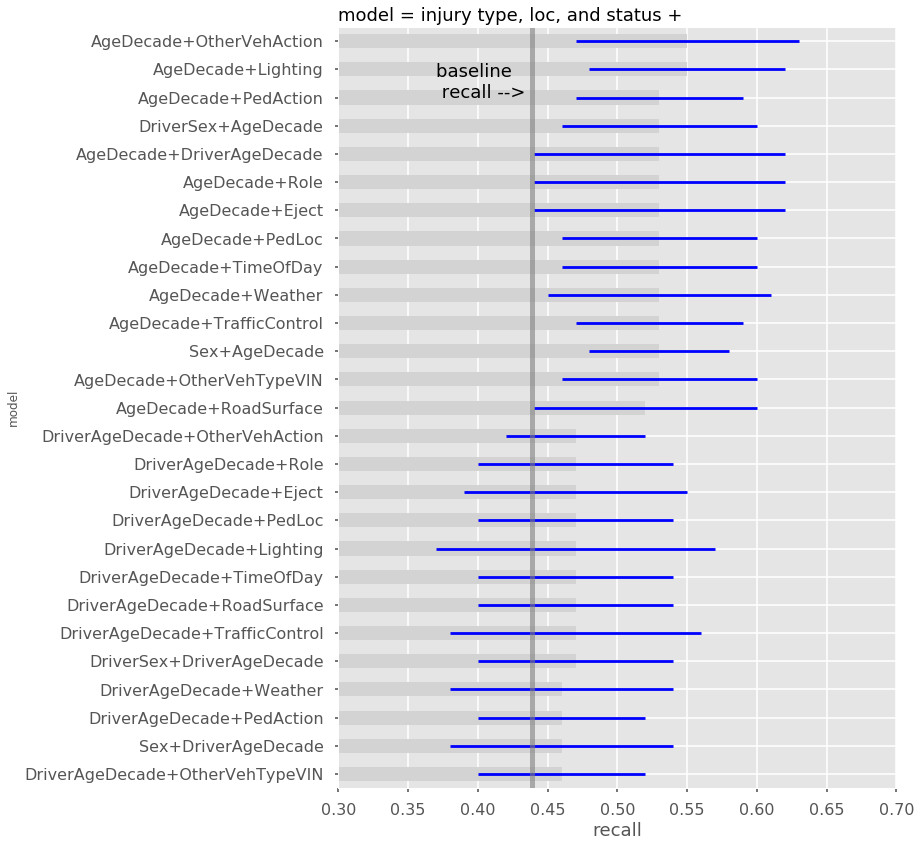

In [21]:
# look more closely at the age variables
md = models[models.index.str.contains('Age')].copy()

# error bars
md['delta low'] = md['recall low'] - md['recall']
md['delta high'] = md['recall high'] - md['recall']
error = md[['delta low','delta high']].T.values

md[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,14),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,24,'baseline \n recall -->',fontsize=18)

add in age by itself to bar graph

In [22]:
%%capture

# let's do only age by itself (with inj vars)

pred=['f_InjuryType','f_InjuryStatus','f_InjuryLoc','f_AgeDecade']

op = an.fitPlotMult(data=ped, pred=pred, N=100)

# add onto models2 dataframe
r = float(an.median_recall(op)[0])
rl = float(an.median_recall(op)[1])
rh = float(an.median_recall(op)[2])

models = models.append(pd.DataFrame(data=[{
                'recall':r,
                'recall low':rl,
                'recall high':rh,
                'delta low':rl-r,
                'delta high':rh-r
                }],index=['AgeDecade']))

limiting variables for easy graphing


In [23]:
models2 = models[models.index.str.contains('Age|VIN|Action')
                &(~models.index.str.contains('Sex|Role'))]

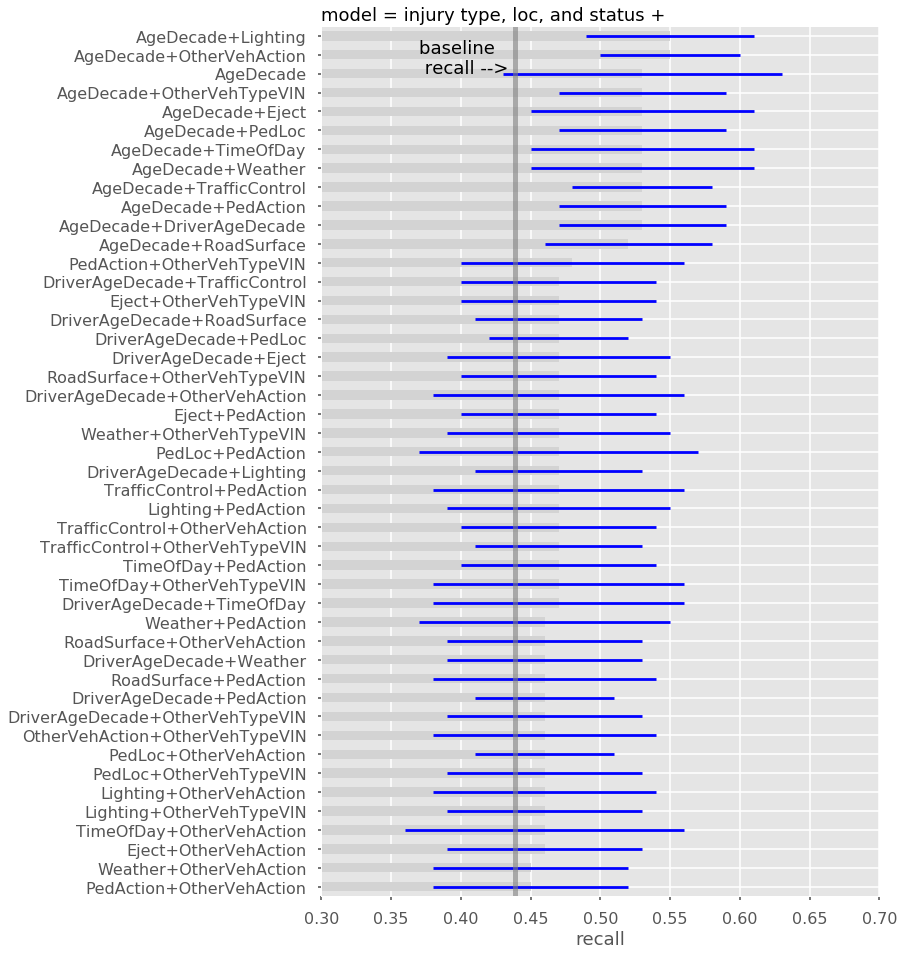

In [24]:
# error bars
error2 = models2[['delta low','delta high']].T.values

# plot
models2[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error2, figsize=(10,16),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,43,'baseline \n recall -->',fontsize=18)

In [25]:
# redo with age under 60

pedUnder60 = ped[ped.f_AgeYear<60]

print pedUnder60.shape
print pedUnder60[pedUnder60.biss_severity_9=='severe'].shape

(14974, 107)
(1154, 107)


In [26]:
%%capture
models = an.varSelect(data=pedUnder60,varOfInt=varOfInt,N=100)

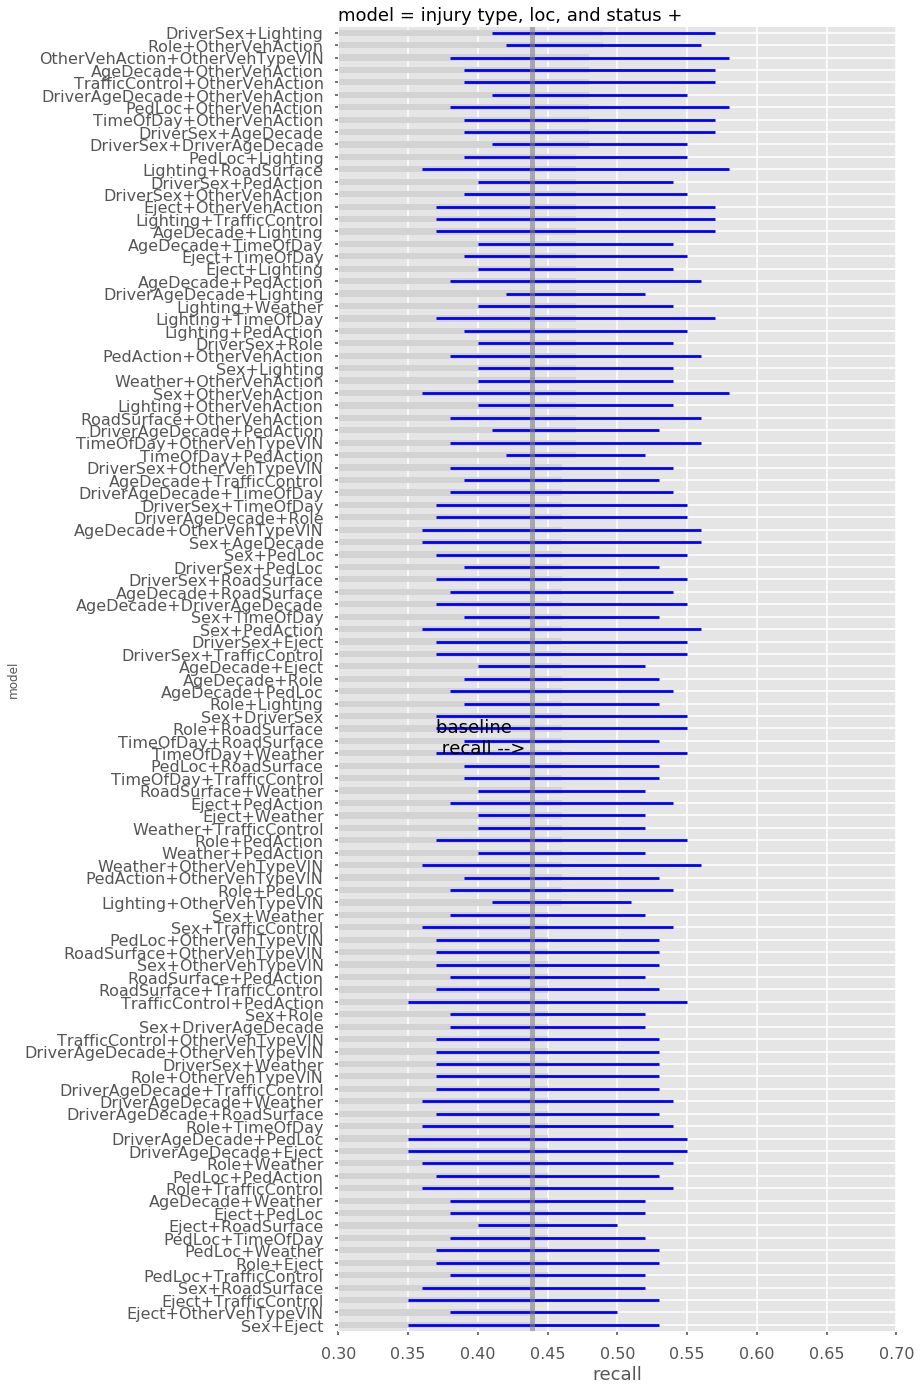

In [27]:
#plot
error = models[['delta low','delta high']].T.values
models[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,24),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,46,'baseline \n recall -->',fontsize=18)

**Takeaways**

* Age is the most important non-injury attribute. It looks like most or all of the improvment in recall is coming from the injured person's age attribute.

* Recall improvement is modest 

### Logit Model Coefficients (scores)

The coefficients for the logistic regression model are calculated using the full dataset (i.e. not splitting into training testing) and the variables decided on based on the recall improvement from the last section. 


Model with the following input variables:
* injury type
* injury status
* injury location
* age
* vehicle type

Optimization terminated successfully.
         Current function value: 0.259716
         Iterations 8


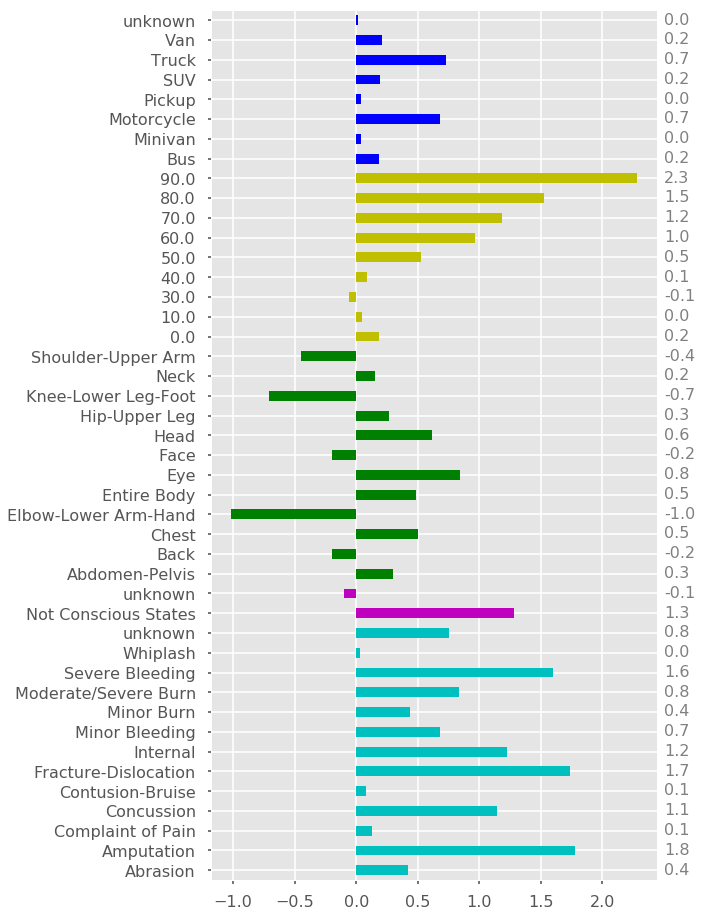

In [28]:
# set up X and y
pred = ["C(f_InjuryType,Treatment(reference='None Visible'))", 
        "C(f_InjuryStatus,Treatment(reference='Conscious states'))", 
        "C(f_InjuryLoc,Treatment(reference='unknown'))",
        "C(f_AgeDecade,Treatment(reference='20.0'))",
        "C(f_OtherVehTypeVIN,Treatment(reference='Car'))",
#        "C(f_OtherVehicleAction,Treatment(reference='unknown'))",

       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

# print out coefficient values (rounded off)
coeff = model.params[1:].tolist()
coeff = [round(x,1) for x in coeff]

for i, v in enumerate(coeff):
    plt.text(2.5 , i - .2 , str(v),fontsize=16,color='grey')

From the precision recall curve, the optimal recall happens at threshold p_th = 0.13. 

\begin{equation}
\log{\frac{p_{th}}{1-p_{th}}} = b_0 + sum of scores_{th}
\end{equation}

This means that all crashes with total score greater than 1.4 are considered severe.

In [29]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.3632211398988932

This model is similar to above but with vehicle action instead of vehicle type.

Model with the following input variables:
* injury type
* injury status
* injury location
* age
* vehicle pre-crash action

Optimization terminated successfully.
         Current function value: 0.257778
         Iterations 8


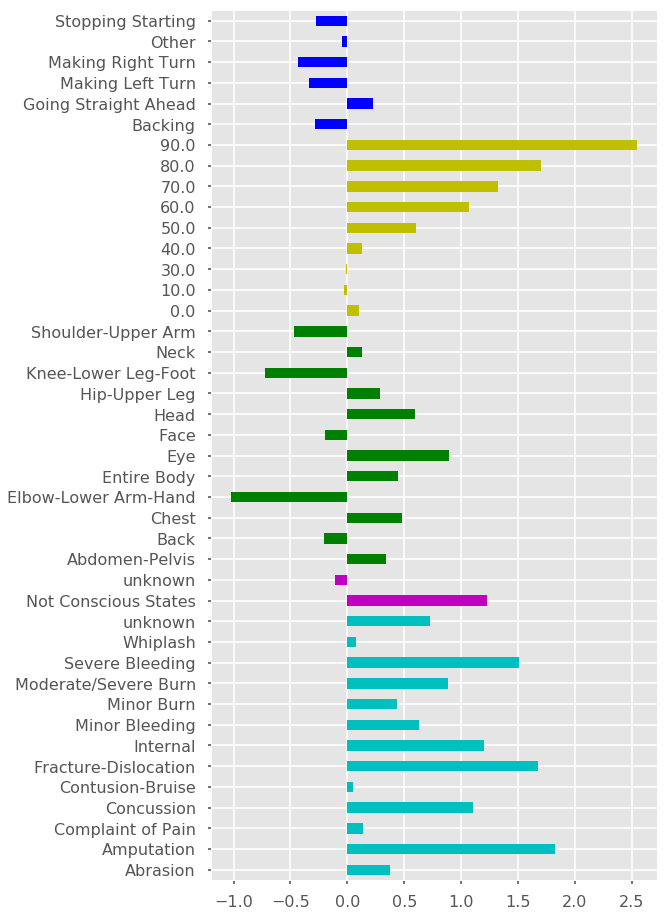

In [30]:
# set up X and y
pred = ["C(f_InjuryType,Treatment(reference='None Visible'))", 
        "C(f_InjuryStatus,Treatment(reference='Conscious states'))", 
        "C(f_InjuryLoc,Treatment(reference='unknown'))",
        "C(f_AgeDecade,Treatment(reference='20.0'))",
#        "C(f_OtherVehTypeVIN,Treatment(reference='Car'))",
        "C(f_OtherVehAction,Treatment(reference='unknown'))",
       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

In [31]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.270381081177864

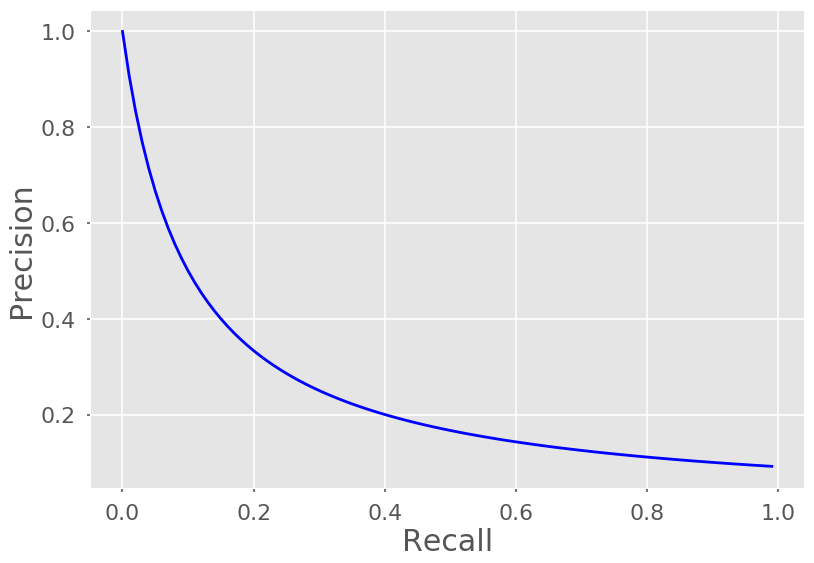

In [32]:
# fake precision - recall curve for presentation slides

t = np.arange(0.0, 1.0, 0.01)
plt.plot(t, .001/(.01*t+.001),'blue')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)